In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder("/data/raf/train", transform=transform)
val_data = datasets.ImageFolder("/data/raf/val", transform=transform)
test_data = datasets.ImageFolder("/data/raf/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class_names = train_data.classes
num_classes = len(class_names)
print("✅ Classes:", class_names)


✅ Classes: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']


In [ ]:
import sys
sys.path.append("models/ResEmoteNet/approach")  # This is where the model is

from ResEmoteNet import ResEmoteNet

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResEmoteNet().to(device)


In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    model.train()
    return correct / total


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc_list = []
    val_acc_list = []
    loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # accumulate per-sample loss
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += batch_size

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)
        avg_loss = running_loss / total  # average per sample

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Accuracy plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_acc_list, label='Train Acc')
    plt.plot(val_acc_list, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(loss_list, label='Avg Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/10 | Avg Loss: 1.5933 | Train Acc: 0.3789 | Val Acc: 0.5445
Epoch 2/10 | Avg Loss: 0.9846 | Train Acc: 0.6489 | Val Acc: 0.6717
Epoch 3/10 | Avg Loss: 0.6764 | Train Acc: 0.7643 | Val Acc: 0.7701
Epoch 4/10 | Avg Loss: 0.4985 | Train Acc: 0.8294 | Val Acc: 0.7753
Epoch 5/10 | Avg Loss: 0.3820 | Train Acc: 0.8727 | Val Acc: 0.8151
Epoch 6/10 | Avg Loss: 0.2958 | Train Acc: 0.9027 | Val Acc: 0.8257
Epoch 7/10 | Avg Loss: 0.2349 | Train Acc: 0.9234 | Val Acc: 0.8304
Epoch 8/10 | Avg Loss: 0.1851 | Train Acc: 0.9404 | Val Acc: 0.8429
Epoch 9/10 | Avg Loss: 0.1529 | Train Acc: 0.9521 | Val Acc: 0.8450
Epoch 10/10 | Avg Loss: 0.1269 | Train Acc: 0.9619 | Val Acc: 0.8474


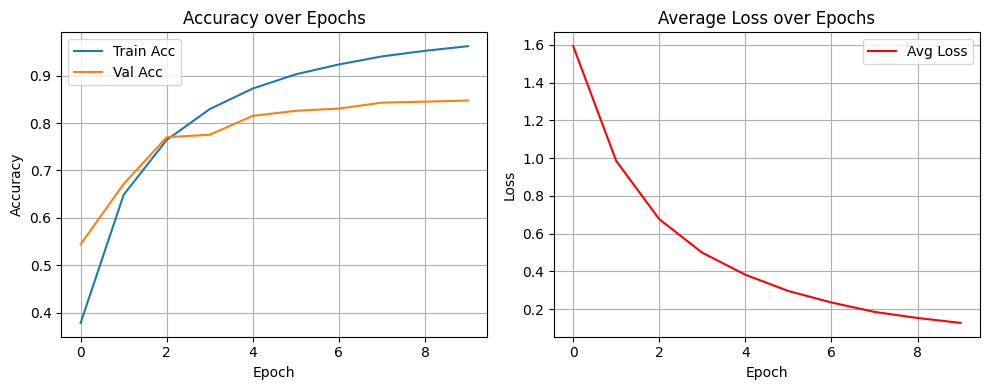

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


✅ Weighted F1 Score: 0.8430

🔍 Classification Report:

              precision    recall  f1-score   support

       angry       0.82      0.79      0.80       898
    contempt       0.96      0.98      0.97       898
     disgust       0.95      0.98      0.96       898
        fear       0.87      0.92      0.90       898
       happy       0.88      0.81      0.84       898
     neutral       0.74      0.72      0.73       898
         sad       0.73      0.68      0.70       898
     suprise       0.80      0.87      0.83       898

    accuracy                           0.84      7184
   macro avg       0.84      0.84      0.84      7184
weighted avg       0.84      0.84      0.84      7184



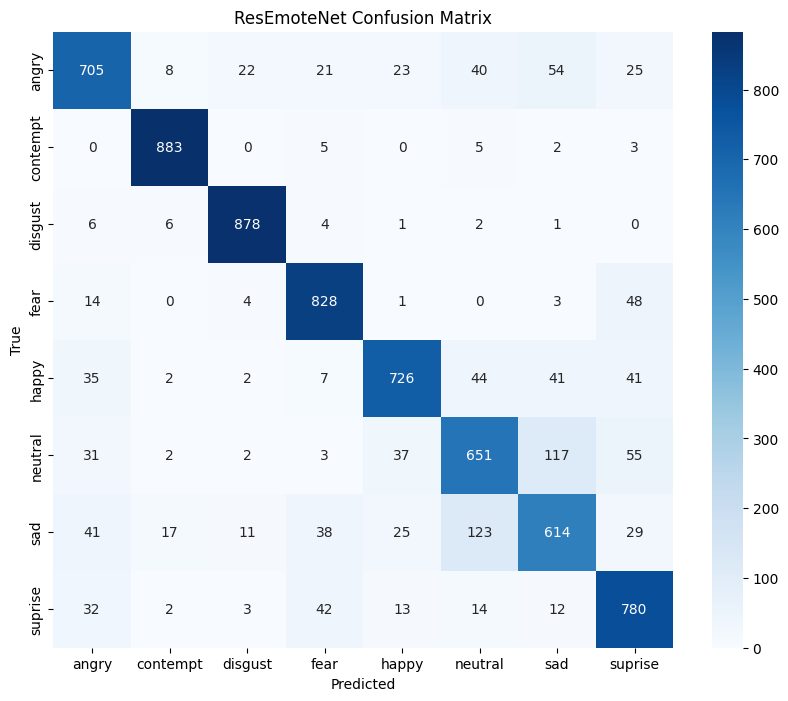

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

# ✅ Classification Report
print("🔍 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("ResEmoteNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
